In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [55]:
class KMeans:
    
    def __init__(self, n_clusters, n_iter=1000, n_init=10, limit=1e-6):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.limit = limit
        self.n_init = n_init
        self.cluster_centers_ = None
        self.error = None
        self.labels = None

    def _reinit(self, path):
        with open(path, 'rb') as f:
            curr_best = pickle.load(f)

        for k in curr_best.__dict__.keys():
            setattr(self, k, getattr(curr_best, k))
    
    def _save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
    
    def _load(self, path):
        with open(path, 'rb') as f:
            return pickle.load(f)

    def init_centers(self, X):
        shuffe_data = np.random.permutation(X)
        return shuffe_data[:self.n_clusters]
        
    def compute_dist(self, X):
        dist = np.zeros((X.shape[0], self.n_clusters))
        for k, center in enumerate(self.cluster_centers_):
            dist[:,k] = np.linalg.norm(X - center, 2, axis=1)
        return dist

    def assign(self, dist_matrix):
        return np.argmin(dist_matrix, axis=1)
    
    def centroids(self, X, labels):
        _centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            _centers[k, :] = np.mean(X[labels == k, :], axis=0)
        return _centers
    
    def get_error(self, X, labels, centers):
        _dist = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            _dist[labels == k] = np.linalg.norm(X[labels == k] - centers[k], axis=1)
        return np.sum(np.square(_dist))
    
    def _train(self, X, centroids=None):
        self.cluster_centers_ = self.init_centers(X) if centroids is None else centroids
        for _iter in range(self.n_iter):
            old_centers = self.cluster_centers_
            dist = self.compute_dist(X)
            labels = self.assign(dist)
            self.cluster_centers_ = self.centroids(X, labels)
            self.error = self.get_error(X, labels, self.cluster_centers_)
    
            if (np.all(old_centers == self.cluster_centers_) or self.error < self.limit):
                break
   
    def fit(self, X, path='./saved_model.pickle', centroids=None, verbose=False):
        curr_best = -1
    
        for _ in range(self.n_init):
            self._train(X, centroids)
            if verbose:
                print ("{:3}/{} :: Error - {}".format(_, self.n_init, self.error))
            
            if curr_best == -1 or self.error < curr_best:
                curr_best = self.error
                self._save(path)
        
        self._reinit(path)
        self.labels = self.predict(X)

    def predict(self, Y):
        _dist = self.compute_dist(Y)
        return self.assign(_dist)

    @classmethod
    def plot_elbow_curve(cls, data, start, end, step):
        """Plots the Curve of distortion vs Number of Clusters against the data.
        Helps you choose an optimal number of clusters"""
        distortions = []
        n_cluster = []
        for i in range (start, end + 1, step):
            n_cluster.append(i)
            temp_obj = KMeans(i)
            temp_obj.fit(X)
            distortions.append(temp_obj.error)

        # plot
        plt.plot(n_cluster, distortions, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        

In [56]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])

In [57]:
k = KMeans(n_clusters=2, n_iter=1000, n_init=10)
k.fit(X, './saved_model.pickle', verbose=True)

SyntaxError: unexpected EOF while parsing (<ipython-input-57-a96bf6f15d8a>, line 2)

In [58]:
k.labels

array([1, 1, 1, 0, 0, 0])

In [59]:
k.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

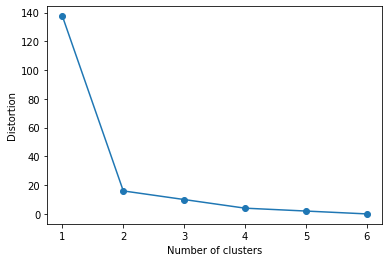

In [54]:
KMeans.plot_elbow_curve(X, 1, 6, 1)